In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import random
import math
from keras.regularizers import l1, l2
from keras.regularizers import l1_l2
from keras.callbacks import EarlyStopping, ModelCheckpoint
import lime
import time

In [2]:
FF_df = pd.read_csv('form_factors.csv')
TD_x_df = pd.read_csv('gpr_total_density_x_200.csv')
TD_y_df = pd.read_csv('gpr_total_density_y_200.csv')

FF_df = FF_df.transpose()
TD_x_df = TD_x_df.transpose()
TD_y_df = TD_y_df.transpose()

for i in range(0,613):
    TD_y_df[i] = TD_y_df[i]-round((TD_y_df[i][0]+TD_y_df[i][199])/2,3)
    
FF_df = (FF_df-FF_df.mean())/FF_df.std()
TD_x_df = (TD_x_df-TD_x_df.mean())/TD_x_df.std()
TD_y_df = (TD_y_df-TD_y_df.mean())/TD_y_df.std()

outlier_column_indexes = set([])

index = 0
for value in TD_y_df.iloc[99]:
    if value > -1:
        outlier_column_indexes.add(index)
    index = index + 1

index = 0 
for value in TD_y_df.iloc[5]:
    if value > 0.30:
        outlier_column_indexes.add(index)
    index = index + 1
    
index = 0 
for value in TD_y_df.iloc[15]:
    if value > 0.30:
        outlier_column_indexes.add(index)
    index = index + 1
    
FF_df = FF_df.drop(outlier_column_indexes, axis=1)
TD_x_df = TD_x_df.drop(outlier_column_indexes, axis=1)
TD_y_df = TD_y_df.drop(outlier_column_indexes, axis=1)

for i in TD_y_df.columns:
    TD_y_df[i] = TD_y_df[i]-round((TD_y_df[i][0]+TD_y_df[i][199])/2,3)

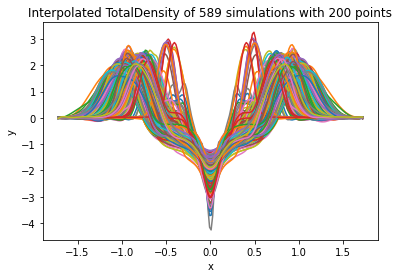

In [3]:
i = 0
for index in TD_x_df.columns:
    plt.plot(TD_x_df[index],TD_y_df[index])
    i = i + 1
    
plt.xlabel('x')
plt.ylabel('y')
plt.title('Interpolated TotalDensity of ' + str(i) + ' simulations with 200 points')
plt.show()

In [4]:
input_data = np.array(FF_df.iloc[: , :-14])
output_data_x = np.array(TD_x_df.iloc[: , :-14])
output_data_y = np.array(TD_y_df.iloc[: , :-14])
print(input_data.shape)
print(output_data_x.shape)
print(output_data_y.shape)

(1000, 575)
(200, 575)
(200, 575)


In [5]:
random.seed(42)
train = random.sample(range(0,input_data.shape[1]),int(input_data.shape[1]*0.8))
test = []
for number in range(0,input_data.shape[1]):
    if not number in train:
        test.append(number)

print(train)
print(len(train))
print(test)
print(len(test))

[114, 25, 281, 250, 228, 142, 104, 558, 89, 432, 32, 30, 95, 223, 238, 517, 27, 203, 429, 225, 459, 284, 6, 163, 565, 348, 553, 159, 220, 344, 568, 94, 389, 99, 367, 352, 270, 44, 470, 127, 387, 80, 300, 370, 196, 71, 46, 233, 296, 81, 560, 103, 542, 548, 464, 373, 166, 379, 363, 214, 273, 73, 175, 571, 83, 236, 194, 138, 506, 473, 327, 539, 285, 112, 350, 518, 431, 393, 397, 28, 117, 420, 16, 412, 161, 205, 137, 33, 108, 467, 482, 290, 448, 540, 490, 486, 335, 255, 202, 452, 468, 329, 234, 513, 135, 529, 126, 381, 287, 275, 134, 382, 299, 219, 554, 298, 204, 185, 501, 70, 260, 252, 528, 386, 24, 440, 56, 78, 321, 525, 405, 549, 216, 305, 564, 197, 195, 441, 239, 538, 128, 283, 5, 443, 369, 58, 349, 274, 384, 136, 497, 328, 174, 57, 150, 222, 533, 232, 1, 430, 368, 520, 256, 390, 91, 259, 54, 320, 152, 504, 409, 311, 101, 447, 191, 411, 82, 276, 271, 0, 306, 165, 511, 9, 421, 457, 157, 122, 29, 123, 483, 40, 43, 374, 248, 35, 272, 64, 65, 337, 243, 572, 84, 536, 435, 310, 442, 479, 496

In [6]:
train_input_values = []
for number in train:
    train_input_values.append(input_data[:,number])
    
train_output_values = []
for number in train:
    train_output_values.append(np.concatenate((output_data_x[:,number],output_data_y[:,number])))

test_input_values = []
for number in test:
    test_input_values.append(input_data[:,number])
    
test_output_values = []
for number in test:
    test_output_values.append(np.concatenate((output_data_x[:,number],output_data_y[:,number])))
    
train_input_values = np.array(train_input_values).astype(np.float32)
train_output_values = np.array(train_output_values).astype(np.float32)
test_input_values = np.array(test_input_values).astype(np.float32)
test_output_values = np.array(test_output_values).astype(np.float32)

print(train_input_values.shape)
print(train_output_values.shape)
print(test_input_values.shape)
print(test_output_values.shape)

(460, 1000)
(460, 400)
(115, 1000)
(115, 400)


In [7]:
def loss(actual,prediction):
    length = int(len(prediction[0])/2)
    
    index = 0
    distance_average_sum = 0
    for data in prediction:
        p_x = data[0:length]
        p_y = data[length:]
        t_x = actual[index][0:length]
        t_y = actual[index][length:]
         
        distance_sum = 0
        for i in range(0,length):
            distance_sum = distance_sum + math.sqrt((t_x[i]-p_x[i])**2 + (t_y[i]-p_y[i])**2)
            
        distance_average_sum = distance_average_sum + distance_sum/length
        index = index + 1
        
    return (distance_average_sum)/len(prediction)

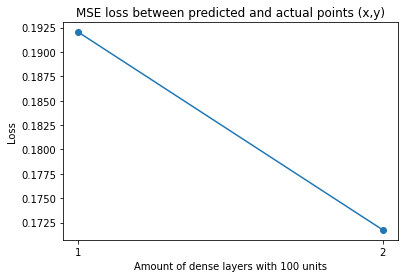


Used time: 30.456412315368652 seconds


In [27]:
def layertesting(max_layers, units, train_input, train_output, test_input, test_output):
    start_time = time.time()
    
    input_length = train_input.shape[1]
    output_length = train_output.shape[1]
    
    loss_score = []
    for model_size in range(1,max_layers+1):
        inputs = keras.Input(shape=(input_length,))
        x = layers.Dense(units, activation="relu")(inputs)
        
        if model_size > 1:
            for i in range(2, model_size+1):
                x = layers.Dense(units, activation="relu")(x)
        
        outputs = layers.Dense(output_length)(x)
        model = keras.Model(inputs=inputs, outputs=outputs)
        model.compile(optimizer='adam', loss='mean_absolute_error')
        
        callbacks = [EarlyStopping(monitor='val_loss', 
                           mode='min', 
                           patience=100, 
                           restore_best_weights=True)]
        
        model.fit(train_input, train_output, batch_size=64, epochs=500, validation_split=0.2, callbacks=callbacks, verbose=0)
        loss_score.append(loss(test_output, model.predict(test_input)))
        
    plt.plot(range(1,max_layers+1,1),loss_score, marker = 'o')
    plt.xticks(range(1, max_layers+1, 1), range(1, max_layers+1, 1))
    plt.xlabel('Amount of dense layers with ' + str(units) + ' units')
    plt.ylabel('Loss')
    plt.title('MSE loss between predicted and actual points (x,y)')
    plt.savefig('layer_testing_' + str(max_layers) + '_' + str(units) + '.png')
    plt.show()
    
    end_time = time.time()
    print('')
    print('Used time: ' + str(end_time - start_time) + ' seconds')
         
layertesting(2, 100, train_input_values, train_output_values, test_input_values, test_output_values)

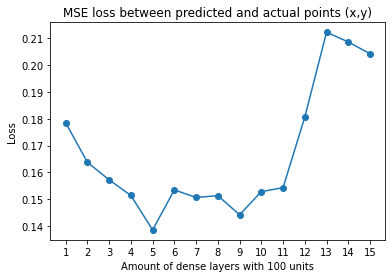


Used time: 322.7659969329834 seconds


In [28]:
layertesting(15, 100, train_input_values, train_output_values, test_input_values, test_output_values)

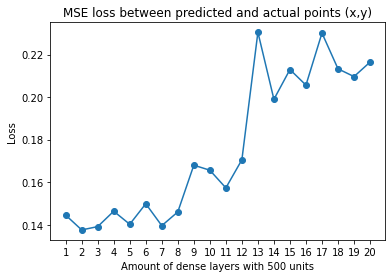


Used time: 1622.5882918834686 seconds


In [29]:
layertesting(20, 500, train_input_values, train_output_values, test_input_values, test_output_values)

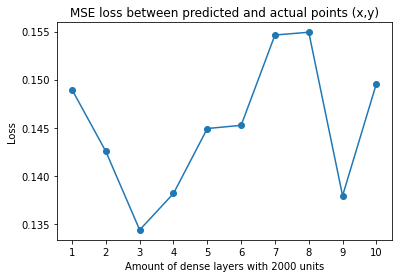


Used time: 4309.15750002861 seconds


In [30]:
layertesting(10, 2000, train_input_values, train_output_values, test_input_values, test_output_values)

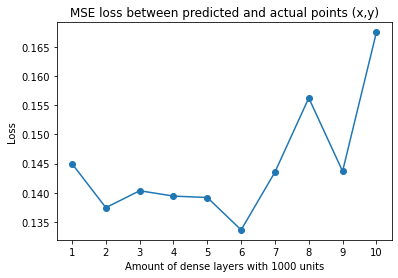


Used time: 1127.968504667282 seconds


In [31]:
layertesting(10, 1000, train_input_values, train_output_values, test_input_values, test_output_values)

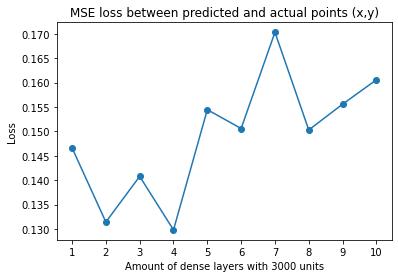


Used time: 7881.900490999222 seconds


In [32]:
layertesting(10, 3000, train_input_values, train_output_values, test_input_values, test_output_values)

Used time for fit and predict: 453.65565252304077 seconds

Used time for fit and predict: 104.00445008277893 seconds



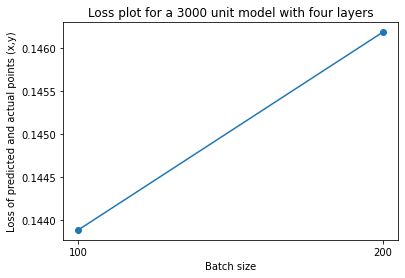

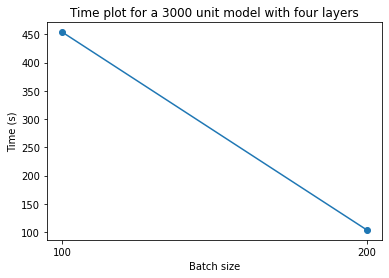


Used time: 558.783650636673 seconds


In [35]:
def batchtesting(model, max_size, increment, train_input, train_output, test_input, test_output):
    general_start_time = time.time()
    
    callbacks = [EarlyStopping(monitor='val_loss', 
                       mode='min', 
                       patience=100, 
                       restore_best_weights=True)]
    times = []
    loss_score = []
    for test_batch_size in range(increment, max_size + 1, increment):
        run_start_time = time.time()
        
        model.fit(train_input, train_output, batch_size=test_batch_size, epochs=500, validation_split=0.2, callbacks=callbacks, verbose=0)
        loss_score.append(loss(test_output, model.predict(test_input)))
        
        run_end_time = time.time()
        
        times.append(run_end_time - run_start_time)
        
        #print('Used time for fit and predict with batch size ' + str(test_batch_size) + ': ' +  + str(run_end_time - run_start_time) + ' seconds')
        #print('')
     
    plt.plot(range(increment, max_size + 1, increment),loss_score, marker = 'o')
    plt.xticks(range(increment, max_size + 1, increment), range(increment, max_size + 1, increment))
    plt.xlabel('Batch size')
    plt.ylabel('Loss of predicted and actual points (x,y)')
    plt.title('Loss plot for a 3000 unit model with four layers')
    plt.savefig('batch_testing_' + str(max_size) + '_' + str(increment) + '.png')
    plt.show()
    
    plt.plot(range(increment, max_size + 1, increment),times, marker = 'o')
    plt.xticks(range(increment, max_size + 1, increment), range(increment, max_size + 1, increment))
    plt.xlabel('Batch size')
    plt.ylabel('Time (s)')
    plt.title('Time plot for a 3000 unit model with four layers')
    plt.savefig('batch_testing_times_' + str(max_size) + '_' + str(increment) + '.png')
    plt.show()
    
    general_end_time = time.time()
    print('')
    print('Used time: ' + str(general_end_time - general_start_time) + ' seconds')

#inputs = keras.Input(shape=(1000,))
#x = layers.Dense(3000, activation="relu")(inputs)
#x = layers.Dense(3000, activation="relu")(x)
#x = layers.Dense(3000, activation="relu")(x)
#x = layers.Dense(3000, activation="relu")(x)
#outputs = layers.Dense(400)(x)
#model = keras.Model(inputs=inputs, outputs=outputs)
#model.compile(optimizer='adam', loss='mean_absolute_error')
           
#batchtesting(model, 200, 100, train_input_values, train_output_values, test_input_values, test_output_values)

Used time for fit and predict: 1015.4648480415344 seconds

Used time for fit and predict: 177.85674953460693 seconds

Used time for fit and predict: 135.97683358192444 seconds

Used time for fit and predict: 244.23891830444336 seconds

Used time for fit and predict: 218.66844058036804 seconds

Used time for fit and predict: 155.92386722564697 seconds

Used time for fit and predict: 107.6501874923706 seconds

Used time for fit and predict: 140.74232697486877 seconds

Used time for fit and predict: 144.45390033721924 seconds

Used time for fit and predict: 99.48847246170044 seconds



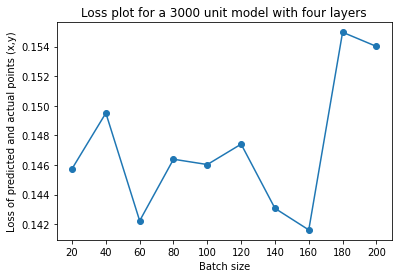

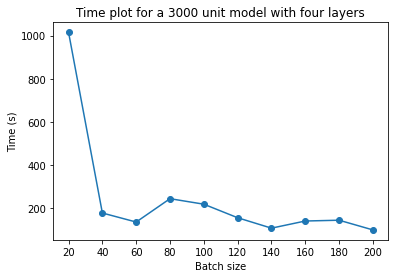


Used time: 2441.7937409877777 seconds


In [36]:
inputs = keras.Input(shape=(1000,))
x = layers.Dense(3000, activation="relu")(inputs)
x = layers.Dense(3000, activation="relu")(x)
x = layers.Dense(3000, activation="relu")(x)
x = layers.Dense(3000, activation="relu")(x)
outputs = layers.Dense(400)(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mean_absolute_error')
           
batchtesting(model, 200, 20, train_input_values, train_output_values, test_input_values, test_output_values)

In [8]:
def batchtesting(model, min_size, max_size, increment, train_input, train_output, test_input, test_output):
    general_start_time = time.time()
    
    callbacks = [EarlyStopping(monitor='val_loss', 
                       mode='min', 
                       patience=100, 
                       restore_best_weights=True)]
    times = []
    loss_score = []
    for test_batch_size in range(min_size, max_size + 1, increment):
        run_start_time = time.time()
        
        model.fit(train_input, train_output, batch_size=test_batch_size, epochs=500, validation_split=0.2, callbacks=callbacks, verbose=0)
        loss_score.append(loss(test_output, model.predict(test_input)))
        
        run_end_time = time.time()
        
        times.append(run_end_time - run_start_time)
             
    plt.plot(range(min_size, max_size + 1, increment),loss_score, marker = 'o')
    plt.xticks(range(min_size, max_size + 1, increment), range(min_size, max_size + 1, increment))
    plt.xlabel('Batch size')
    plt.ylabel('Loss of predicted and actual points (x,y)')
    plt.title('Loss plot for a 3000 unit model with four layers')
    plt.savefig('batch_testing_' + str(min_size) + '_' + str(max_size) + '_' + str(increment) + '.png')
    plt.show()
    
    plt.plot(range(min_size, max_size + 1, increment),times, marker = 'o')
    plt.xticks(range(min_size, max_size + 1, increment), range(min_size, max_size + 1, increment))
    plt.xlabel('Batch size')
    plt.ylabel('Time (s)')
    plt.title('Time plot for a 3000 unit model with four layers')
    plt.savefig('batch_testing_times_' + str(min_size) + '_' + str(max_size) + '_' + str(increment) + '.png')
    plt.show()
    
    general_end_time = time.time()
    print('')
    print('Used time: ' + str(general_end_time - general_start_time) + ' seconds')

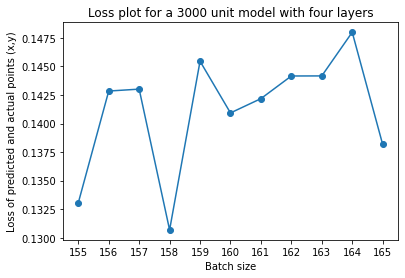

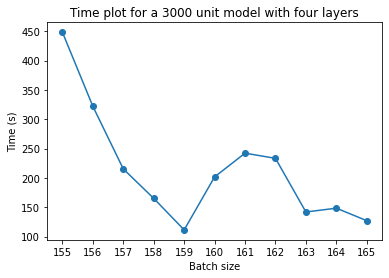


Used time: 2358.156001329422 seconds


In [9]:
inputs = keras.Input(shape=(1000,))
x = layers.Dense(3000, activation="relu")(inputs)
x = layers.Dense(3000, activation="relu")(x)
x = layers.Dense(3000, activation="relu")(x)
x = layers.Dense(3000, activation="relu")(x)
outputs = layers.Dense(400)(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mean_absolute_error')
           
batchtesting(model, 155, 165, 1, train_input_values, train_output_values, test_input_values, test_output_values)

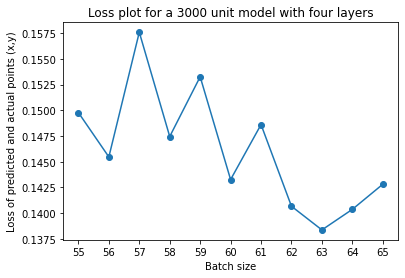

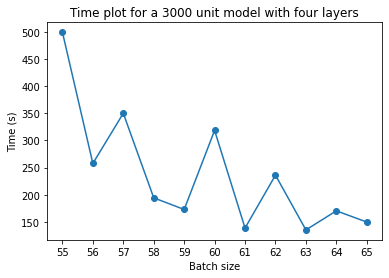


Used time: 2623.435256242752 seconds


In [10]:
inputs = keras.Input(shape=(1000,))
x = layers.Dense(3000, activation="relu")(inputs)
x = layers.Dense(3000, activation="relu")(x)
x = layers.Dense(3000, activation="relu")(x)
x = layers.Dense(3000, activation="relu")(x)
outputs = layers.Dense(400)(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mean_absolute_error')
           
batchtesting(model, 55, 65, 1, train_input_values, train_output_values, test_input_values, test_output_values)

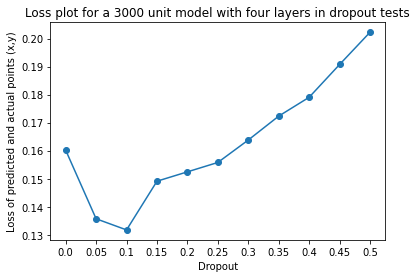

NameError: name 'min_size' is not defined

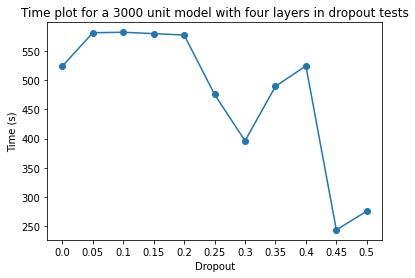

In [18]:
def droptesting(min_per, max_per, increment, train_input, train_output, test_input, test_output):
    drops = np.round(np.arange(min_per, max_per + increment, increment),2)
    
    general_start_time = time.time()
    callbacks = [EarlyStopping(monitor='val_loss', 
                       mode='min', 
                       patience=100, 
                       restore_best_weights=True)]
    times = []
    loss_score = []
    for drop_per in drops:
        run_start_time = time.time()
        
        inputs = keras.Input(shape=(1000,))
        x = layers.Dense(3000, activation="relu")(inputs)
        x = layers.Dropout(drop_per, seed=42)(x)
        x = layers.Dense(3000, activation="relu")(x)
        x = layers.Dropout(drop_per, seed=42)(x)
        x = layers.Dense(3000, activation="relu")(x)
        x = layers.Dropout(drop_per, seed=42)(x)
        x = layers.Dense(3000, activation="relu")(x)
        x = layers.Dropout(drop_per, seed=42)(x)
        outputs = layers.Dense(400)(x)
        
        model = keras.Model(inputs=inputs, outputs=outputs)
        model.compile(optimizer='adam', loss='mean_absolute_error')
        
        model.fit(train_input, train_output, batch_size=158, epochs=500, validation_split=0.2, callbacks=callbacks, verbose=0)
        loss_score.append(loss(test_output, model.predict(test_input)))
        
        run_end_time = time.time()
        
        times.append(run_end_time - run_start_time)
        
    plt.plot(drops,loss_score, marker = 'o')
    plt.xticks(drops, drops)
    plt.xlabel('Dropout')
    plt.ylabel('Loss of predicted and actual points (x,y)')
    plt.title('Loss plot for a 3000 unit model with four layers in dropout tests')
    plt.savefig('dropout_testing_' + str(min_per) + '_' + str(max_per) + '_' + str(increment) + '.png')
    plt.show()
    
    plt.plot(drops,times, marker = 'o')
    plt.xticks(drops, drops)
    plt.xlabel('Dropout')
    plt.ylabel('Time (s)')
    plt.title('Time plot for a 3000 unit model with four layers in dropout tests')
    plt.savefig('dropout_testing_times_' + str(min_per) + '_' + str(max_per) + '_' + str(increment) + '.png')
    plt.show()
    
    general_end_time = time.time()
    print('')
    print('Used time: ' + str(general_end_time - general_start_time) + ' seconds')
    
droptesting(0.00, 0.50, 0.05, train_input_values, train_output_values, test_input_values, test_output_values)  

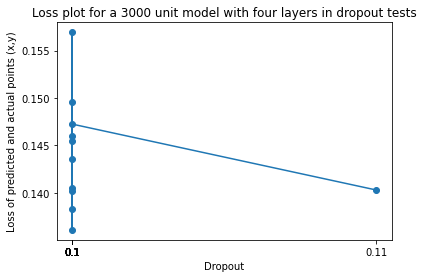

NameError: name 'min_size' is not defined

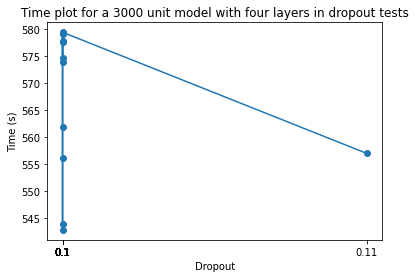

In [19]:
droptesting(0.095, 0.105, 0.001, train_input_values, train_output_values, test_input_values, test_output_values) 

In [34]:
import statistics as st

def metrics(actual,prediction):
    amount = int(actual.shape[0])
    length = int(actual.shape[1]/2)
    
    index = 0
    loss_list = []
    for data in prediction:
        p_x = data[0:length]
        p_y = data[length:]
        t_x = actual[index][0:length]
        t_y = actual[index][length:]
         
        distance_sum = 0
        for i in range(0,length):
            distance_sum = distance_sum + math.sqrt((t_x[i]-p_x[i])**2 + (t_y[i]-p_y[i])**2)
            
        loss_list.append(distance_sum/length)
        index = index + 1
     
    average_loss = sum(loss_list)/amount
    mode_loss = st.mode(np.round(loss_list,3))
    median_loss = st.median(np.round(loss_list,3))
    
    return [average_loss, mode_loss, median_loss]

In [37]:


#general_start_time = time.time()

#callbacks = [EarlyStopping(monitor='val_loss', 
#                       mode='min', 
#                       patience=100, 
#                       restore_best_weights=True)]

#inputs = keras.Input(shape=(1000,))
#x = layers.Dense(3000, activation="relu")(inputs)
#x = layers.Dropout(0.1, seed=42)(x)
#x = layers.Dense(3000, activation="relu")(x)
#x = layers.Dropout(0.1, seed=42)(x)
#x = layers.Dense(3000, activation="relu")(x)
#x = layers.Dropout(0.1, seed=42)(x)
#x = layers.Dense(3000, activation="relu")(x)
#x = layers.Dropout(0.1, seed=42)(x)
#outputs = layers.Dense(400)(x)
#model = keras.Model(inputs=inputs, outputs=outputs)
#model.compile(optimizer='adam', loss='mean_absolute_error')

#model.fit(train_input_values, train_output_values, batch_size=158, epochs=500, validation_split=0.2, callbacks=callbacks, verbose=2)
#results = metrics(test_output_values, model.predict(test_input_values))

#general_end_time = time.time()

#print('Loss is: ' + str(results[0]))
#print('Loss mode is: ' + str(results[1]))
#print('Loss median is: ' + str(results[2]))
#print('Used time: ' + str(general_end_time - general_start_time) + ' seconds')

Epoch 1/500
3/3 - 2s - loss: 1.6328 - val_loss: 0.7417
Epoch 2/500
3/3 - 1s - loss: 0.6612 - val_loss: 0.6916
Epoch 3/500
3/3 - 1s - loss: 0.4875 - val_loss: 0.4171
Epoch 4/500
3/3 - 1s - loss: 0.3803 - val_loss: 0.2845
Epoch 5/500
3/3 - 1s - loss: 0.2773 - val_loss: 0.2334
Epoch 6/500
3/3 - 1s - loss: 0.2456 - val_loss: 0.2138
Epoch 7/500
3/3 - 1s - loss: 0.2150 - val_loss: 0.2139
Epoch 8/500
3/3 - 1s - loss: 0.1998 - val_loss: 0.1778
Epoch 9/500
3/3 - 1s - loss: 0.1788 - val_loss: 0.1642
Epoch 10/500
3/3 - 1s - loss: 0.1680 - val_loss: 0.1602
Epoch 11/500
3/3 - 1s - loss: 0.1631 - val_loss: 0.1535
Epoch 12/500
3/3 - 1s - loss: 0.1576 - val_loss: 0.1506
Epoch 13/500
3/3 - 1s - loss: 0.1531 - val_loss: 0.1532
Epoch 14/500
3/3 - 1s - loss: 0.1503 - val_loss: 0.1460
Epoch 15/500
3/3 - 1s - loss: 0.1559 - val_loss: 0.1481
Epoch 16/500
3/3 - 1s - loss: 0.1518 - val_loss: 0.1560
Epoch 17/500
3/3 - 1s - loss: 0.1492 - val_loss: 0.1712
Epoch 18/500
3/3 - 1s - loss: 0.1571 - val_loss: 0.1583
E

KeyboardInterrupt: 